# Interpolacja Lagrange'a i Newtona

In [2]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from collections.abc import Callable
import ipympl
%matplotlib ipympl

## Generowanie wartości x

In [3]:
def generate_chebyshev_roots(n: int, a: np.float64, b: np.float64):
  return np.array([(a+b)/2 + (b-a)/2 * np.cos((2*k+1)/(2*n) * np.pi) for k  in range(n)], dtype=np.float64)

def generate_function_uniform_nodes(n: int, interval: tuple[np.float64, np.float64], func):
  a,b= interval[0], interval[1]
  xs = np.linspace(a,b,n)
  tups = []
  for x in xs:
    tups.append((x,func(x)))
  return np.array(tups)

def generate_function_chebyshev_nodes(n: int, interval: tuple[np.float64, np.float64], func):
  a,b= interval[0], interval[1]
  xs = generate_chebyshev_roots(n,a,b)
  tups = []
  for x in xs:
    tups.append((x,func(x)))
  return np.array(tups)


## Interpolacja Lagrange'a

In [4]:
def get_lagrange_interpolation_func(nodes: np.ndarray[(np.float64, np.float64)]) -> Callable[[np.float64], np.float64]:
  n = len(nodes)
  x_nodes = nodes[:, 0]
  y_nodes = nodes[:, 1]
  def coefficient(k):
    return np.prod([1/(x_nodes[k] - x_nodes[i]) for i in range(n) if i != k])
  coefficients = np.array([coefficient(k) for k in range(n)])
  
  def polymial_term(x,k):
    return np.prod([(x - x_nodes[i]) for i in range(n) if i!=k])
  
  return lambda x: np.sum(y_nodes * coefficients * np.array([polymial_term(x,k) for k in range(n)]))

## Interpolacja Newtona

In [5]:
def divided_difference_table(nodes: np.ndarray[(np.float64, np.float64)]) -> np.ndarray:
  n = len(nodes)
  nodes_x = nodes[:,0]
  nodes_y = nodes[:,1]
  dp = np.ndarray((n,n), dtype=np.longdouble)
  dp[:,0] = nodes_y
  for i in range(1,n):
    for j in range(1,i+1):
      dp[i,j] = (dp[i,j-1] - dp[i-1,j-1])/(nodes_x[i] - nodes_x[i-j])
  
  return dp

def get_newton_interpolation_func(nodes: np.ndarray[(np.float64, np.float64)]) -> Callable[[np.float64], np.float64]:
  n = len(nodes)
  nodes_x = nodes[:,0]
  dp = divided_difference_table(nodes)
  
  def func(x):
    result = dp[n-1,n-1]
    for i in range(n-2,-1,-1):
      result = result * (x-nodes_x[i]) + dp[i,i]
    return result

  return func
  

## Błąd pomiarowy

In [6]:
NUMBER_OF_PROBES = 101

def get_max_error(func, interpolation_func, interval):
  xs = np.linspace(interval[0], interval[1], NUMBER_OF_PROBES)
  return max([np.abs(func(x) - interpolation_func(x)) for x in xs])

def get_squared_error(func, interpolation_func, interval):
  xs = np.linspace(interval[0], interval[1], NUMBER_OF_PROBES)
  return np.sqrt(sum([(func(x) - interpolation_func(x))**2 for x in xs])) / NUMBER_OF_PROBES

## Wizualizacja

In [7]:
def plot_function(
    x_values: np.ndarray[np.float64], 
    func: Callable[[np.float64], np.float64], 
    nodes: np.ndarray[(np.float64, np.float64)] | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: tuple[float, float] | None = None,
    x_scale: str = 'linear',
    y_scale: str = 'linear',
    function_name: str = 'Funkcja bazowa',
    nodes_name: str = 'Węzły interpolacji'
):
    y_values = np.array([func(x) for x in x_values])

    plt.plot(x_values, y_values, label=function_name)
    if nodes is not None:
        plt.scatter(nodes[:, 0], nodes[:, 1], color='red', label=nodes_name)
    
    plt.xscale(x_scale)
    plt.yscale(y_scale)
    
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Wizualizacja funkcji')


In [8]:
m = 5
k = 0.5
interval = (-5,5)
N = 100

func = lambda x: x**2 - m*np.cos((np.pi * x) / k)

In [9]:
nodes_linear = generate_function_uniform_nodes(N,interval, func)
nodes_chebyshev = generate_function_chebyshev_nodes(N,interval, func)
lagrange_linear = get_lagrange_interpolation_func(nodes_linear)
lagrange_chebyshev = get_lagrange_interpolation_func(nodes_chebyshev)
newton_linear = get_newton_interpolation_func(nodes_linear)
newton_chebyshev = get_newton_interpolation_func(nodes_chebyshev)

In [10]:
nodes_linear = generate_function_uniform_nodes(100,interval, func)
get_max_error(func, get_lagrange_interpolation_func(nodes_linear), interval)

536870727.32576734

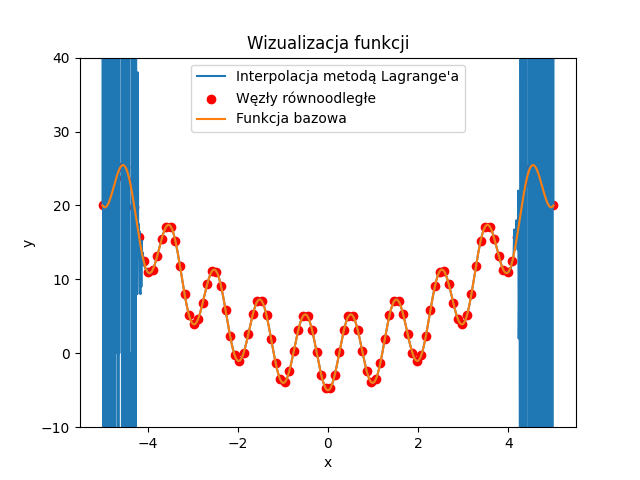

In [11]:

plt.clf()
plot_function(np.linspace(interval[0], interval[1], 1000), lagrange_linear, nodes_linear, y_lim=(-10,40), function_name="Interpolacja metodą Lagrange'a", nodes_name="Węzły równoodległe")
plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10,40))
plt.show()


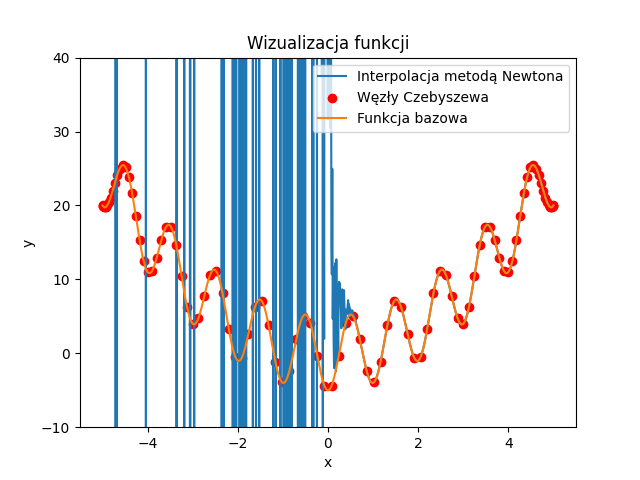

In [12]:
plt.clf()
plot_function(np.linspace(interval[0], interval[1], 1000), newton_chebyshev, nodes_chebyshev, y_lim=(-10,40), function_name="Interpolacja metodą Newtona", nodes_name="Węzły Czebyszewa")
plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10,40))
plt.show()

In [13]:
PATH_TO_SAVE_MAIN = os.path.join('.', 'img')
PATH_TO_SAVE_LINEAR = os.path.join(PATH_TO_SAVE_MAIN, 'linear')
PATH_TO_SAVE_CHEBYSHEV = os.path.join(PATH_TO_SAVE_MAIN, 'chebyshev')
PATH_TO_SAVE_DATA = os.path.join('.', 'data')

shutil.rmtree(PATH_TO_SAVE_MAIN)
os.makedirs(PATH_TO_SAVE_DATA, exist_ok=True)

FUNCTIONS = [get_lagrange_interpolation_func, get_newton_interpolation_func]
NAMES = ['Lagrange\'a', 'Newtona']
FUNCITON_NAMES = ['Interpolacja metodą Lagrange\'a', 'Interpolacja metodą Newtona']
DIRS = ['lagrange', 'newton']

# Initialize a list to store data for the CSV
data_records = []

# Declare max number of nodes
N = 200

for i in range(1, N):
  for j, function in enumerate(FUNCTIONS):
    nodes_linear = generate_function_uniform_nodes(i, interval, func)
    nodes_chebyshev = generate_function_chebyshev_nodes(i, interval, func)
    interpolation_linear = function(nodes_linear)
    interpolation_chebyshev = function(nodes_chebyshev)

    error_max_linear = get_max_error(func, interpolation_linear, interval)
    error_squared_linear = get_squared_error(func, interpolation_linear, interval)
    error_max_chebyshev = get_max_error(func, interpolation_chebyshev, interval)
    error_squared_chebyshev = get_squared_error(func, interpolation_chebyshev, interval)

    # Save plots for linear nodes
    plot_function(np.linspace(interval[0], interval[1], 1000), interpolation_linear, nodes_linear, y_lim=(-10, 40), nodes_name='Węzły Równoodległe', function_name=FUNCITON_NAMES[j])
    plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10, 40))
    directory_lagrange = os.path.join(PATH_TO_SAVE_LINEAR, DIRS[j])
    os.makedirs(directory_lagrange, exist_ok=True)
    plt.savefig(os.path.join(directory_lagrange, f'Interpolacja {NAMES[j]} Węzły Liniowe i={i}'))
    plt.clf()

    # Save plots for Chebyshev nodes
    directory_chebyshev = os.path.join(PATH_TO_SAVE_CHEBYSHEV, DIRS[j])
    os.makedirs(directory_chebyshev, exist_ok=True)
    plot_function(np.linspace(interval[0], interval[1], 1000), interpolation_chebyshev, nodes_chebyshev, y_lim=(-10, 40), nodes_name='Węzły Czebyszewa', function_name=FUNCITON_NAMES[j])
    plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10, 40))
    plt.savefig(os.path.join(PATH_TO_SAVE_CHEBYSHEV, DIRS[j], f'Interpolacja {NAMES[j]} Węzły Czebyszewa i={i}'))
    plt.clf()

    # Append data for CSV
    data_records.append({
      'Number of Nodes': i,
      'Node Type': 'Linear',
      'Interpolation Type': DIRS[j],
      'Max Error': error_max_linear,
      'Squared Error': error_squared_linear
    })
    data_records.append({
      'Number of Nodes': i,
      'Node Type': 'Chebyshev',
      'Interpolation Type': DIRS[j],
      'Max Error': error_max_chebyshev,
      'Squared Error': error_squared_chebyshev
    })

# Save data to CSV
df = pd.DataFrame(data_records)
df.to_csv(os.path.join(PATH_TO_SAVE_DATA, 'interpolation_errors.csv'), index=False)